In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import random
import pandas as pd

from typing import Tuple, Dict, List
from collections import defaultdict

In [2]:
DEVICE = "cpu"
BATCH_SIZE = 64
TRAIN_PATH = "./data/train.csv"
TEST_PATH = "./data/test.csv"

## Datasets

In [3]:
class MNISTDataset(torch.utils.data.Dataset):

    def __init__(self,
                 path: str,
                 train: bool=True) -> None:
        
        df = pd.read_csv(path)
        self.train = train
        if train:
            self.X = df.iloc[:, 1:].values
            self.y = df.iloc[:, 0].values
        else:
            self.X = df.values

    def __len__(self) -> int:
        return self.X.shape[0]
    
    def __getitem__(self, idx: int):
        if self.train:
            return torch.tensor(self.X[idx, :], dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.long)
        else:
            return torch.tensor(self.X[idx, :], dtype=torch.float32)

In [4]:
train_set = MNISTDataset(path=TRAIN_PATH, train=True)
test_set = MNISTDataset(path=TEST_PATH, train=False)

In [5]:
def display_random_image(seed: int=None):
    if seed:
        random.seed(a=seed)
        torch.manual_seed(seed)
    random_idx = random.randint(a=0, b=len(train_set)-1)
    plt.imshow(
        X=train_set[random_idx][0].reshape(28, 28, 1)
    )
    plt.title(label=f"Number: {train_set[random_idx][1]}")


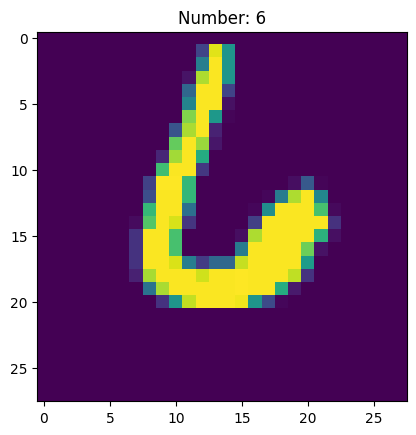

In [6]:
display_random_image(seed=None)

## Dataloaders

In [7]:
train_dataloader = DataLoader(dataset=train_set,
                              batch_size=64,
                              shuffle=BATCH_SIZE)
test_dataloader = DataLoader(dataset=test_set,
                             shuffle=False,
                             batch_size=BATCH_SIZE)

In [8]:
next(iter(train_dataloader))[0].shape

torch.Size([64, 784])

## Model

In [9]:
class DigitClassifier(nn.Module):
    
    def __init__(self):

        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(in_features=784, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=32),
            nn.ReLU(),
            nn.Linear(in_features=32, out_features=10)
        )
    
    def forward(self,
                X: torch.Tensor) -> float:
        return self.net(X)

## Training

In [10]:
def train_step(model: nn.Module,
               loss_fn: nn.Module,
               optimizer: torch.optim.Optimizer,
               dataloader: DataLoader) -> Tuple[float]:
    
    model.train()
    model.to(DEVICE)
    train_loss, train_acc = 0, 0
    for X_batch, y_batch in dataloader:
        
        X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)

        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_acc += torch.sum(torch.argmax(y_pred, dim=-1).squeeze() == y_batch.squeeze()).item()/ BATCH_SIZE
    
    train_loss /= len(dataloader)
    train_acc /= len(dataloader)


    return train_loss, train_acc

@torch.no_grad()
def eval_step(model: nn.Module,
               loss_fn: nn.Module,
               dataloader: DataLoader) -> Tuple[float]:
    
    model.eval()
    model.to(DEVICE)
    eval_loss, eval_acc = 0, 0
    
    for X_batch, y_batch in dataloader:
        
        X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)

        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)

        eval_loss += loss.item()
        eval_acc += torch.sum(torch.argmax(y_pred, dim=-1).squeeze() == y_batch.squeeze()).item()/ 64
    
    eval_loss /= len(dataloader)
    eval_acc /= len(dataloader)


    return eval_loss, eval_acc

In [11]:
def train(model: nn.Module,
          loss_fn: nn.Module,
          optimizer: torch.optim.Optimizer,
          train_dataloader: DataLoader,
          test_dataloader: DataLoader,
          epochs: int) -> Dict[str, List[float]]:
    
    
    results = defaultdict(list)

    for epoch in range(1, epochs+1):
        
        train_loss, train_acc = train_step(model=model,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           dataloader=train_dataloader)
        
        print(f"epoch {epoch} train_loss:{train_loss:.3f} train_acc:{train_acc}")
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
    
    return results

In [12]:
model = DigitClassifier()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
    params=model.parameters(),
    lr=1e-2
)

In [13]:
results = train(model=model,
                loss_fn=loss_fn,
                optimizer=optimizer,
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                epochs=10)

epoch 1 train_loss:0.348 train_acc:0.8910530821917808
epoch 2 train_loss:0.133 train_acc:0.95771499238965
epoch 3 train_loss:0.087 train_acc:0.9723173515981736
epoch 4 train_loss:0.063 train_acc:0.979261796042618
epoch 5 train_loss:0.049 train_acc:0.9842560882800608
epoch 6 train_loss:0.033 train_acc:0.9888460806697108
epoch 7 train_loss:0.025 train_acc:0.9914145738203958
epoch 8 train_loss:0.017 train_acc:0.9942446727549468
epoch 9 train_loss:0.012 train_acc:0.9955051369863014
epoch 10 train_loss:0.008 train_acc:0.9970747716894978


## Result Visualization

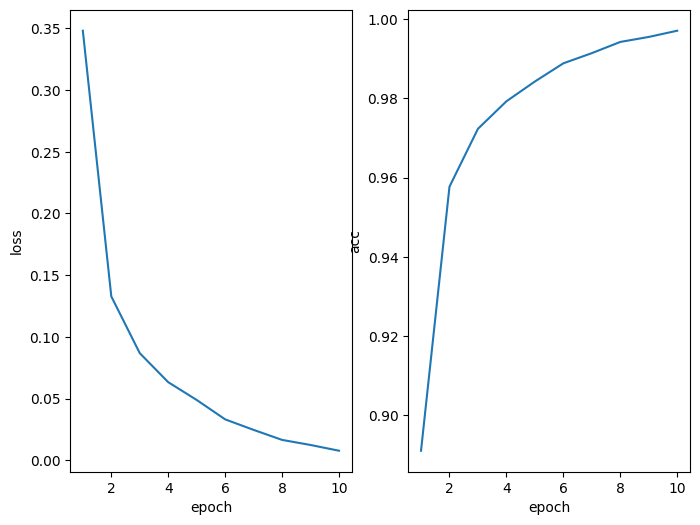

In [14]:
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(1, 2, figsize=(8, 6))

axs[0].plot(np.arange(1, 11), results["train_loss"])
axs[1].plot(np.arange(1, 11), results["train_acc"])

axs[0].set_xlabel('epoch')
axs[0].set_ylabel('loss')

axs[1].set_xlabel('epoch')
axs[1].set_ylabel('acc')

plt.show()
fig.tight_layout()

## Saving Model

In [15]:
torch.save(obj=model.state_dict(),
           f="./weights/simple_model.pt")